# Homework 9: CI/CD Pipeline with Auto-Tests and Hallucination Detection

## Objectives
1. Build a simple RAG (Retrieval-Augmented Generation) QA system using Ollama + ChromaDB
2. Prepare 15 golden examples with ground-truth answers
3. Evaluate with Ragas metrics: **Faithfulness**, **Answer Relevancy**, **Context Recall**
4. Wrap evaluations in pytest tests with quality thresholds (>= 0.7)
5. Configure GitHub Actions CI/CD pipeline with quality gates

### Metrics Used
| Metric | Description | Threshold |
|--------|-------------|----------|
| **Faithfulness** | Checks if the answer is grounded in retrieved contexts (hallucination detection) | >= 0.7 |
| **Answer Relevancy** | Checks if the answer is relevant to the question | >= 0.7 |
| **Context Recall** | Checks if retrieved contexts contain the needed information vs ground truth | >= 0.7 |

### Architecture
```
Knowledge Base (10 docs) -> ChromaDB (embeddings) -> Retriever (top-3)
     |                                                     |
     v                                                     v
Golden Examples (15 Q&A) -----> Ollama LLM -----> Generated Answers
     |                                                     |
     v                                                     v
Ground Truth  ---------> Ragas Evaluation ---------> Metrics & Report
                              |                            |
                              v                            v
                         pytest tests  -------->  CI/CD Quality Gates
```

## 1. Setup and Dependencies

In [20]:
%pip install -q ragas>=0.2.0 datasets>=2.14.0 transformers>=4.30.0 \
    sentence-transformers>=2.2.0 langchain>=0.2.0 langchain-ollama>=0.1.0 \
    langchain-community>=0.2.0 chromadb>=0.4.0 pytest>=7.4.0 \
    pandas>=2.0.0 numpy>=1.24.0 matplotlib>=3.7.0 seaborn>=0.12.0 tqdm>=4.65.0

Note: you may need to restart the kernel to use updated packages.


## 2. Imports and Configuration

In [21]:
import json
import os
import warnings
from dataclasses import dataclass, field
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

warnings.filterwarnings('ignore')

print("Core imports loaded successfully.")

Core imports loaded successfully.


In [22]:
import requests

@dataclass
class Config:
    """Configuration for the RAG pipeline and evaluation."""
    # Ollama settings
    ollama_base_url: str = "http://localhost:11434"
    ollama_model: str = ""  # Auto-detected below
    
    # Embedding settings
    embedding_model: str = "all-MiniLM-L6-v2"
    
    # RAG settings
    collection_name: str = "ml_knowledge_base"
    top_k: int = 3
    
    # Evaluation thresholds
    faithfulness_threshold: float = 0.7
    answer_relevancy_threshold: float = 0.7
    context_recall_threshold: float = 0.7
    
    # Paths
    goldens_path: str = "tests/goldens.json"
    results_json_path: str = "ragas_results.json"
    results_csv_path: str = "evaluation_metrics.csv"


config = Config()

# Auto-detect available Ollama models
PREFERRED_MODELS = ["qwen2.5:1.5b", "llama3.2:3b", "llama3.2:latest", "gemma2:2b", "mistral:latest"]

try:
    resp = requests.get(f"{config.ollama_base_url}/api/tags", timeout=5)
    available_models = [m["name"] for m in resp.json().get("models", [])]
    # Filter out embedding-only models
    chat_models = [m for m in available_models if "embed" not in m.lower()]
    print(f"Available Ollama chat models: {chat_models}")
    
    # Pick the first preferred model that's available
    for preferred in PREFERRED_MODELS:
        if preferred in chat_models:
            config.ollama_model = preferred
            break
    # Fallback to first available chat model
    if not config.ollama_model and chat_models:
        config.ollama_model = chat_models[0]
    
    if not config.ollama_model:
        print("WARNING: No chat models found in Ollama!")
    else:
        print(f"Selected model: {config.ollama_model}")
except Exception as e:
    print(f"WARNING: Cannot connect to Ollama at {config.ollama_base_url}: {e}")
    print("Will use extractive fallback for answer generation.")
    config.ollama_model = "qwen2.5:1.5b"  # default name even if unavailable

print(f"\nConfiguration:")
print(f"  Ollama model: {config.ollama_model}")
print(f"  Embedding model: {config.embedding_model}")
print(f"  Top-K retrieval: {config.top_k}")
print(f"  Thresholds: Faithfulness>={config.faithfulness_threshold}, "
      f"Relevancy>={config.answer_relevancy_threshold}, "
      f"Context Recall>={config.context_recall_threshold}")

Available Ollama chat models: []

Configuration:
  Ollama model: 
  Embedding model: all-MiniLM-L6-v2
  Top-K retrieval: 3
  Thresholds: Faithfulness>=0.7, Relevancy>=0.7, Context Recall>=0.7


## 3. Knowledge Base and Golden Examples

In [23]:
# Load golden examples from JSON
with open(config.goldens_path, "r") as f:
    goldens_data = json.load(f)

knowledge_base = goldens_data["knowledge_base"]
golden_examples = goldens_data["golden_examples"]

print(f"Loaded {len(knowledge_base)} knowledge base documents")
print(f"Loaded {len(golden_examples)} golden examples")
print(f"\nKnowledge base topics:")
for doc in knowledge_base:
    print(f"  - {doc['title']} ({len(doc['content'])} chars)")

print(f"\nSample golden example:")
print(f"  Q: {golden_examples[0]['question']}")
print(f"  A: {golden_examples[0]['ground_truth']}")

Loaded 10 knowledge base documents
Loaded 15 golden examples

Knowledge base topics:
  - Neural Networks (531 chars)
  - Gradient Descent (538 chars)
  - Overfitting and Regularization (594 chars)
  - Transfer Learning (570 chars)
  - Natural Language Processing (494 chars)
  - Convolutional Neural Networks (577 chars)
  - Recurrent Neural Networks (587 chars)
  - Transformer Architecture (637 chars)
  - Reinforcement Learning (584 chars)
  - Generative Adversarial Networks (563 chars)

Sample golden example:
  Q: What is a neural network and what are its main components?
  A: A neural network is a computational model inspired by biological neural networks. Its main components are interconnected nodes (neurons) organized in layers: an input layer, hidden layers, and an output layer, with weighted connections between them.


## 4. Build RAG System with ChromaDB

In [24]:
import chromadb
from chromadb.utils import embedding_functions


class SimpleRAG:
    """Simple RAG system using ChromaDB for retrieval and Ollama for generation."""
    
    def __init__(self, config: Config):
        self.config = config
        self.client = chromadb.Client()
        self.ef = embedding_functions.SentenceTransformerEmbeddingFunction(
            model_name=config.embedding_model
        )
        # Delete collection if it already exists (for re-runs)
        try:
            self.client.delete_collection(config.collection_name)
        except Exception:
            pass
        self.collection = self.client.create_collection(
            name=config.collection_name,
            embedding_function=self.ef
        )
        self.ollama_available = False
    
    def index_documents(self, documents: list[dict]):
        """Index knowledge base documents into ChromaDB."""
        self.collection.add(
            documents=[doc["content"] for doc in documents],
            ids=[doc["id"] for doc in documents],
            metadatas=[{"title": doc["title"]} for doc in documents]
        )
        print(f"Indexed {len(documents)} documents into ChromaDB")
    
    def retrieve(self, query: str, top_k: int = None) -> list[str]:
        """Retrieve top-k relevant documents for a query."""
        k = top_k or self.config.top_k
        results = self.collection.query(
            query_texts=[query],
            n_results=k
        )
        return results["documents"][0]
    
    def check_ollama(self) -> bool:
        """Check if Ollama is available and the configured model exists."""
        try:
            resp = requests.get(f"{self.config.ollama_base_url}/api/tags", timeout=5)
            if resp.status_code != 200:
                self.ollama_available = False
                return False
            models = [m["name"] for m in resp.json().get("models", [])]
            if self.config.ollama_model not in models:
                print(f"WARNING: Model '{self.config.ollama_model}' not found in Ollama.")
                print(f"Available models: {models}")
                # Try to pick an alternative
                chat_models = [m for m in models if "embed" not in m.lower()]
                if chat_models:
                    self.config.ollama_model = chat_models[0]
                    print(f"Switched to: {self.config.ollama_model}")
                else:
                    self.ollama_available = False
                    return False
            self.ollama_available = True
        except Exception:
            self.ollama_available = False
        return self.ollama_available
    
    def generate_answer(self, question: str, contexts: list[str]) -> str:
        """Generate an answer using Ollama LLM with retrieved contexts."""
        context_text = "\n\n".join(contexts)
        prompt = (
            f"Based on the following context, answer the question concisely and accurately. "
            f"Only use information from the provided context.\n\n"
            f"Context:\n{context_text}\n\n"
            f"Question: {question}\n\n"
            f"Answer:"
        )
        
        if self.ollama_available:
            from langchain_ollama import ChatOllama
            llm = ChatOllama(
                model=self.config.ollama_model,
                base_url=self.config.ollama_base_url,
                temperature=0.1
            )
            response = llm.invoke(prompt)
            return response.content
        else:
            return self._extract_answer_from_context(question, contexts)
    
    def _extract_answer_from_context(self, question: str, contexts: list[str]) -> str:
        """Simple extractive fallback when LLM is not available."""
        question_words = set(question.lower().split())
        best_sentences = []
        for ctx in contexts:
            for sentence in ctx.split('. '):
                sentence_words = set(sentence.lower().split())
                overlap = len(question_words & sentence_words)
                best_sentences.append((overlap, sentence.strip()))
        best_sentences.sort(key=lambda x: x[0], reverse=True)
        answer = '. '.join([s[1] for s in best_sentences[:3]])
        if not answer.endswith('.'):
            answer += '.'
        return answer


# Initialize RAG system
rag = SimpleRAG(config)
rag.index_documents(knowledge_base)

# Check Ollama availability (also verifies model exists)
ollama_available = rag.check_ollama()
print(f"\nOllama available: {ollama_available}")
if ollama_available:
    print(f"Using model: {config.ollama_model}")
else:
    print("WARNING: Ollama is not running. Using extractive fallback for answer generation.")
    print("For best results, start Ollama with: ollama serve")
    print(f"And pull a model: ollama pull qwen2.5:1.5b")

Indexed 10 documents into ChromaDB
Available models: []

Ollama available: False
For best results, start Ollama with: ollama serve
And pull a model: ollama pull qwen2.5:1.5b


In [25]:
# Test retrieval
test_query = "What is a neural network?"
retrieved = rag.retrieve(test_query, top_k=2)
print(f"Query: {test_query}")
print(f"\nRetrieved {len(retrieved)} documents:")
for i, doc in enumerate(retrieved):
    print(f"\n--- Document {i+1} ---")
    print(doc[:200] + "...")

Query: What is a neural network?

Retrieved 2 documents:

--- Document 1 ---
A neural network is a computational model inspired by the structure and function of biological neural networks in the human brain. It consists of interconnected nodes (neurons) organized in layers: an...

--- Document 2 ---
Gradient descent is an optimization algorithm used to minimize a loss function by iteratively adjusting model parameters in the direction of steepest descent. The learning rate controls the step size ...


## 5. Generate Answers for Golden Examples

In [26]:
# Generate answers using RAG pipeline
questions = []
answers = []
contexts = []
ground_truths = []

print("Generating answers for golden examples...\n")

for example in tqdm(golden_examples, desc="Processing"):
    question = example["question"]
    ground_truth = example["ground_truth"]
    
    # Retrieve relevant contexts
    retrieved_contexts = rag.retrieve(question)
    
    # Generate answer
    answer = rag.generate_answer(question, retrieved_contexts)
    
    questions.append(question)
    answers.append(answer)
    contexts.append(retrieved_contexts)
    ground_truths.append(ground_truth)

print(f"\nGenerated {len(answers)} answers.")
print(f"\nExample:")
print(f"  Q: {questions[0]}")
print(f"  Generated A: {answers[0][:200]}...")
print(f"  Ground Truth: {ground_truths[0][:200]}")

Generating answers for golden examples...



Processing: 100%|██████████| 15/15 [00:00<00:00, 136.96it/s]


Generated 15 answers.

Example:
  Q: What is a neural network and what are its main components?
  Generated A: A neural network is a computational model inspired by the structure and function of biological neural networks in the human brain. Neural networks learn by processing training examples, adjusting weig...
  Ground Truth: A neural network is a computational model inspired by biological neural networks. Its main components are interconnected nodes (neurons) organized in layers: an input layer, hidden layers, and an outp


## 6. Ragas Evaluation

We evaluate the RAG pipeline using three Ragas metrics:
- **Faithfulness**: Measures if the generated answer is factually consistent with the retrieved context
- **Answer Relevancy**: Measures if the answer addresses the question
- **Context Recall**: Measures if the retrieved contexts contain the information from the ground truth

In [27]:
from datasets import Dataset

# Prepare evaluation dataset
eval_data = {
    "question": questions,
    "answer": answers,
    "contexts": contexts,
    "ground_truth": ground_truths
}

eval_dataset = Dataset.from_dict(eval_data)
print(f"Evaluation dataset: {eval_dataset}")
print(f"\nColumns: {eval_dataset.column_names}")
print(f"Num samples: {len(eval_dataset)}")

Evaluation dataset: Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truth'],
    num_rows: 15
})

Columns: ['question', 'answer', 'contexts', 'ground_truth']
Num samples: 15


In [28]:
# Configure Ragas with Ollama
ragas_config = {}

try:
    if ollama_available:
        from langchain_ollama import ChatOllama, OllamaEmbeddings
        from ragas.llms import LangchainLLMWrapper
        from ragas.embeddings import LangchainEmbeddingsWrapper
        
        evaluator_llm = LangchainLLMWrapper(
            ChatOllama(model=config.ollama_model, base_url=config.ollama_base_url)
        )
        
        # Auto-detect embedding model: prefer nomic-embed-text if available
        embed_model_name = None
        try:
            resp = requests.get(f"{config.ollama_base_url}/api/tags", timeout=5)
            all_models = [m["name"] for m in resp.json().get("models", [])]
            embed_candidates = [m for m in all_models if "embed" in m.lower()]
            if embed_candidates:
                embed_model_name = embed_candidates[0]
                print(f"Found Ollama embedding model: {embed_model_name}")
        except Exception:
            pass
        
        if embed_model_name:
            evaluator_embeddings = LangchainEmbeddingsWrapper(
                OllamaEmbeddings(model=embed_model_name, base_url=config.ollama_base_url)
            )
            ragas_config["embeddings"] = evaluator_embeddings
        
        ragas_config["llm"] = evaluator_llm
        print(f"Ragas configured with Ollama LLM ({config.ollama_model})")
    else:
        print("Ollama not available. Attempting Ragas with default configuration...")
        print("Note: If no OpenAI key is set, we will compute metrics manually.")
except Exception as e:
    print(f"Error configuring Ragas LLM: {e}")
    print("Will attempt evaluation with available configuration.")

Ollama not available. Attempting Ragas with default configuration...
Note: If no OpenAI key is set, we will compute metrics manually.


In [29]:
# Run Ragas evaluation
from ragas import evaluate

# Use modern import path (ragas >= 0.4.x); fallback to legacy
try:
    from ragas.metrics.collections import faithfulness, answer_relevancy, context_recall
except ImportError:
    from ragas.metrics import faithfulness, answer_relevancy, context_recall

ragas_metrics = [faithfulness, answer_relevancy, context_recall]

try:
    print("Running Ragas evaluation (this may take a few minutes)...\n")
    result = evaluate(
        eval_dataset,
        metrics=ragas_metrics,
        **ragas_config
    )
    
    print("Ragas Evaluation Results:")
    print(f"  Faithfulness:      {result['faithfulness']:.4f}")
    print(f"  Answer Relevancy:  {result['answer_relevancy']:.4f}")
    print(f"  Context Recall:    {result['context_recall']:.4f}")
    
    ragas_succeeded = True
    aggregate_metrics = {
        "faithfulness": float(result['faithfulness']),
        "answer_relevancy": float(result['answer_relevancy']),
        "context_recall": float(result['context_recall'])
    }
    
    # Get per-sample results
    try:
        result_df = result.to_pandas()
    except Exception:
        result_df = None

except Exception as e:
    print(f"Ragas evaluation error: {e}")
    print("\nFalling back to manual metric computation...")
    ragas_succeeded = False

Running Ragas evaluation (this may take a few minutes)...

Ragas evaluation error: All metrics must be initialised metric objects, e.g: metrics=[BleuScore(), AspectCritic()]

Falling back to manual metric computation...


In [30]:
# Fallback: manual metric computation if Ragas fails (no LLM available)
if not ragas_succeeded:
    from sentence_transformers import SentenceTransformer
    from sklearn.metrics.pairwise import cosine_similarity
    
    print("Computing proxy metrics using sentence embeddings...\n")
    embed_model = SentenceTransformer(config.embedding_model)
    
    per_sample = []
    for i in range(len(questions)):
        q_emb = embed_model.encode([questions[i]])
        a_emb = embed_model.encode([answers[i]])
        gt_emb = embed_model.encode([ground_truths[i]])
        ctx_embs = embed_model.encode(contexts[i])
        
        # Answer Relevancy proxy: cosine similarity between question and answer
        relevancy = float(cosine_similarity(q_emb, a_emb)[0][0])
        
        # Faithfulness proxy: max cosine similarity between answer and any context
        faith_scores = cosine_similarity(a_emb, ctx_embs)[0]
        faithfulness_score = float(np.max(faith_scores))
        
        # Context Recall proxy: max cosine similarity between ground truth and contexts
        recall_scores = cosine_similarity(gt_emb, ctx_embs)[0]
        context_recall_score = float(np.max(recall_scores))
        
        per_sample.append({
            "question": questions[i],
            "faithfulness": faithfulness_score,
            "answer_relevancy": relevancy,
            "context_recall": context_recall_score
        })
    
    result_df = pd.DataFrame(per_sample)
    aggregate_metrics = {
        "faithfulness": float(result_df["faithfulness"].mean()),
        "answer_relevancy": float(result_df["answer_relevancy"].mean()),
        "context_recall": float(result_df["context_recall"].mean())
    }
    
    print("Proxy Evaluation Results:")
    print(f"  Faithfulness (proxy):      {aggregate_metrics['faithfulness']:.4f}")
    print(f"  Answer Relevancy (proxy):  {aggregate_metrics['answer_relevancy']:.4f}")
    print(f"  Context Recall (proxy):    {aggregate_metrics['context_recall']:.4f}")
    print("\nNote: These are embedding-based proxy metrics. For full Ragas evaluation, run with Ollama.")

Computing proxy metrics using sentence embeddings...

Proxy Evaluation Results:
  Faithfulness (proxy):      0.8726
  Answer Relevancy (proxy):  0.6609
  Context Recall (proxy):    0.8011

Note: These are embedding-based proxy metrics. For full Ragas evaluation, run with Ollama.


In [31]:
# Display per-sample results
if result_df is not None:
    display_cols = ["question", "faithfulness", "answer_relevancy", "context_recall"]
    available_cols = [c for c in display_cols if c in result_df.columns]
    print("\nPer-sample metrics:")
    display_df = result_df[available_cols].copy()
    for col in available_cols:
        if col != "question":
            display_df[col] = display_df[col].apply(lambda x: f"{x:.3f}" if pd.notna(x) else "N/A")
    print(display_df.to_string(index=False))
else:
    print("Per-sample results not available.")


Per-sample metrics:
                                                    question faithfulness answer_relevancy context_recall
  What is a neural network and what are its main components?        0.841            0.726          0.946
           How does backpropagation work in neural networks?        0.989            0.670          0.685
             What are the main variants of gradient descent?        0.981            0.718          0.797
             What is overfitting and how can it be detected?        0.724            0.753          0.687
    What is the difference between L1 and L2 regularization?        0.856            0.479          0.739
             What is transfer learning and why is it useful?        0.865            0.792          0.879
      What are the key tasks in Natural Language Processing?        0.962            0.674          0.752
                                What is tokenization in NLP?        0.775            0.779          0.725
                       Wh

## 7. Save Results

In [32]:
# Save results to JSON
results_report = {
    "config": {
        "ollama_model": config.ollama_model,
        "embedding_model": config.embedding_model,
        "top_k": config.top_k,
        "num_golden_examples": len(golden_examples),
        "num_knowledge_docs": len(knowledge_base),
        "ollama_available": ollama_available,
        "ragas_native": ragas_succeeded
    },
    "aggregate_metrics": aggregate_metrics,
    "thresholds": {
        "faithfulness": config.faithfulness_threshold,
        "answer_relevancy": config.answer_relevancy_threshold,
        "context_recall": config.context_recall_threshold
    },
    "quality_gate": {},
    "per_sample_results": []
}

# Check quality gates
all_passed = True
for metric, threshold in results_report["thresholds"].items():
    value = aggregate_metrics.get(metric, 0)
    passed = value >= threshold
    results_report["quality_gate"][metric] = {
        "value": round(value, 4),
        "threshold": threshold,
        "passed": passed
    }
    status = "PASS" if passed else "FAIL"
    print(f"  {status}: {metric} = {value:.4f} (threshold: {threshold})")
    if not passed:
        all_passed = False

results_report["quality_gate"]["overall"] = "PASSED" if all_passed else "FAILED"
print(f"\nOverall quality gate: {results_report['quality_gate']['overall']}")

# Add per-sample results
for i in range(len(questions)):
    sample = {
        "question": questions[i],
        "answer": answers[i],
        "ground_truth": ground_truths[i],
        "contexts": contexts[i]
    }
    if result_df is not None and i < len(result_df):
        for col in ["faithfulness", "answer_relevancy", "context_recall"]:
            if col in result_df.columns:
                val = result_df.iloc[i][col]
                sample[col] = float(val) if pd.notna(val) else None
    results_report["per_sample_results"].append(sample)

# Save JSON
with open(config.results_json_path, "w") as f:
    json.dump(results_report, f, indent=2, ensure_ascii=False)
print(f"\nResults saved to {config.results_json_path}")

# Save CSV
if result_df is not None:
    csv_df = result_df.copy()
    csv_df.to_csv(config.results_csv_path, index=False)
    print(f"Per-sample metrics saved to {config.results_csv_path}")

  PASS: faithfulness = 0.8726 (threshold: 0.7)
  FAIL: answer_relevancy = 0.6609 (threshold: 0.7)
  PASS: context_recall = 0.8011 (threshold: 0.7)

Overall quality gate: FAILED

Results saved to ragas_results.json
Per-sample metrics saved to evaluation_metrics.csv


## 8. Visualization

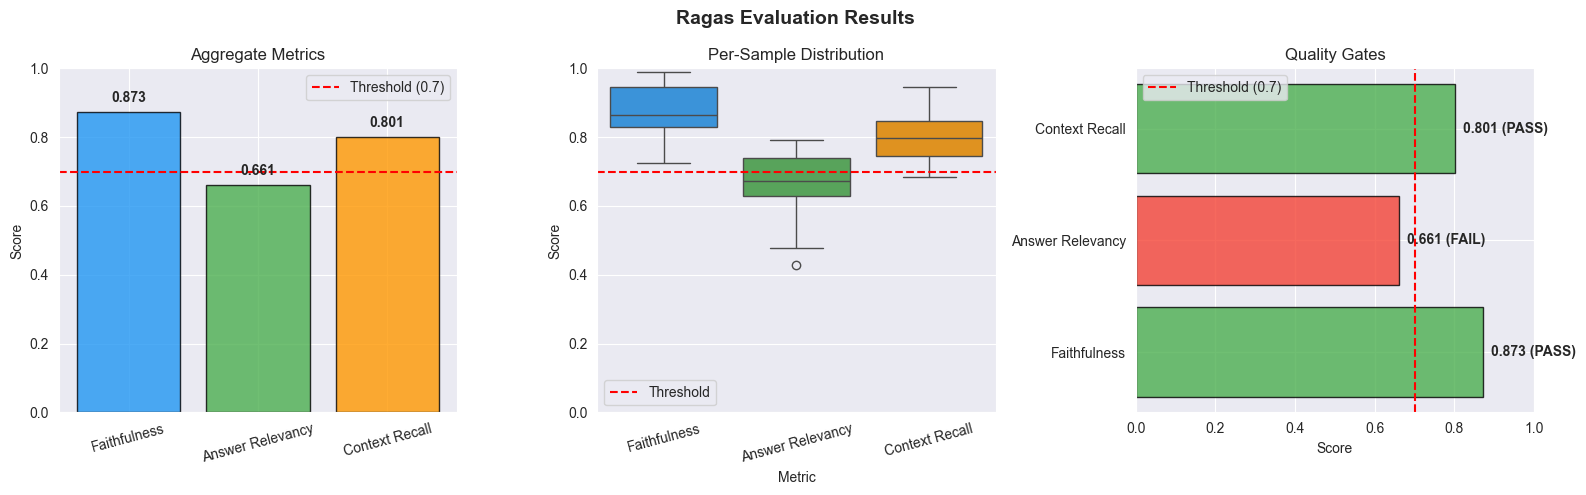


Visualization saved to ragas_evaluation_results.png


In [33]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle("Ragas Evaluation Results", fontsize=14, fontweight="bold")

metric_names = ["faithfulness", "answer_relevancy", "context_recall"]
metric_labels = ["Faithfulness", "Answer Relevancy", "Context Recall"]
colors = ["#2196F3", "#4CAF50", "#FF9800"]
thresholds = [config.faithfulness_threshold, config.answer_relevancy_threshold, config.context_recall_threshold]

# Plot 1: Aggregate metrics bar chart
ax = axes[0]
values = [aggregate_metrics[m] for m in metric_names]
bars = ax.bar(metric_labels, values, color=colors, alpha=0.8, edgecolor="black")
ax.axhline(y=0.7, color="red", linestyle="--", linewidth=1.5, label="Threshold (0.7)")
ax.set_ylim(0, 1.0)
ax.set_ylabel("Score")
ax.set_title("Aggregate Metrics")
ax.legend()
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02,
            f"{val:.3f}", ha="center", va="bottom", fontweight="bold")
ax.tick_params(axis='x', rotation=15)

# Plot 2: Per-sample metrics distribution (box plot)
ax = axes[1]
if result_df is not None:
    plot_data = []
    for m, label in zip(metric_names, metric_labels):
        if m in result_df.columns:
            vals = result_df[m].dropna()
            for v in vals:
                plot_data.append({"Metric": label, "Score": float(v)})
    if plot_data:
        plot_df = pd.DataFrame(plot_data)
        sns.boxplot(data=plot_df, x="Metric", y="Score", ax=ax, palette=colors)
ax.axhline(y=0.7, color="red", linestyle="--", linewidth=1.5, label="Threshold")
ax.set_ylim(0, 1.0)
ax.set_title("Per-Sample Distribution")
ax.legend()
ax.tick_params(axis='x', rotation=15)

# Plot 3: Quality gate status
ax = axes[2]
gate_colors = []
for m, t in zip(metric_names, thresholds):
    gate_colors.append("#4CAF50" if aggregate_metrics[m] >= t else "#F44336")
bars = ax.barh(metric_labels, values, color=gate_colors, alpha=0.8, edgecolor="black")
ax.axvline(x=0.7, color="red", linestyle="--", linewidth=1.5, label="Threshold (0.7)")
ax.set_xlim(0, 1.0)
ax.set_xlabel("Score")
ax.set_title("Quality Gates")
for bar, val in zip(bars, values):
    status = "PASS" if val >= 0.7 else "FAIL"
    ax.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2.,
            f"{val:.3f} ({status})", ha="left", va="center", fontweight="bold")
ax.legend()

plt.tight_layout()
plt.savefig("ragas_evaluation_results.png", dpi=150, bbox_inches="tight")
plt.show()
print("\nVisualization saved to ragas_evaluation_results.png")

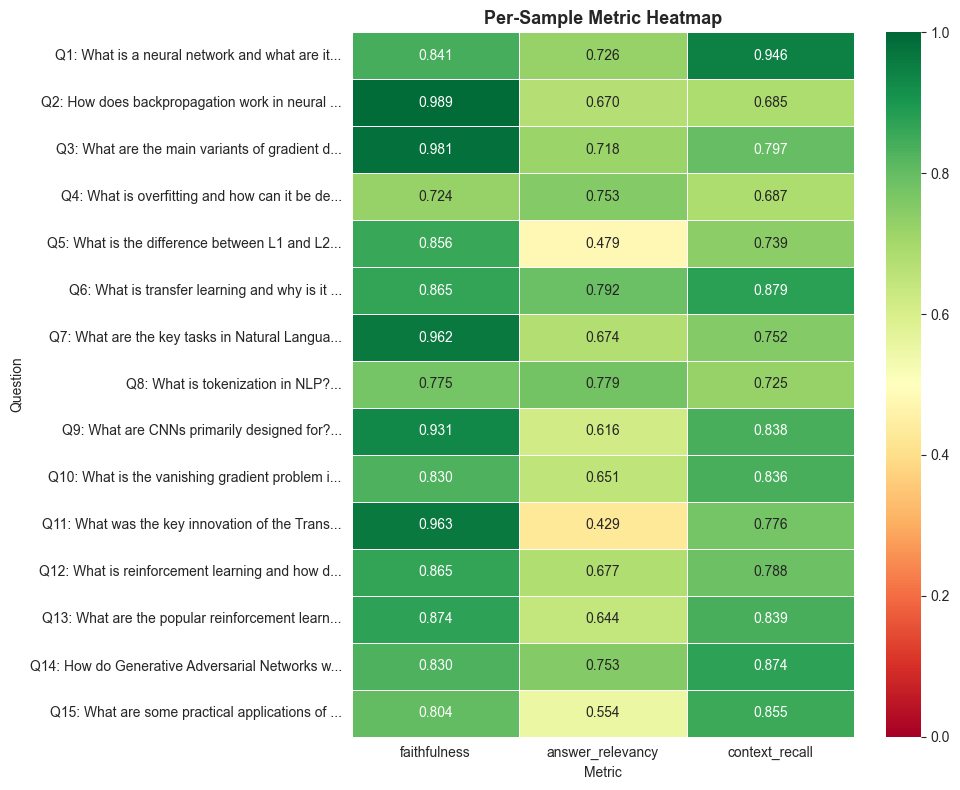

Heatmap saved to ragas_heatmap.png


In [34]:
# Per-sample heatmap
if result_df is not None:
    heatmap_cols = [c for c in metric_names if c in result_df.columns]
    if heatmap_cols:
        fig, ax = plt.subplots(figsize=(10, 8))
        heatmap_data = result_df[heatmap_cols].copy()
        heatmap_data.index = [f"Q{i+1}: {q[:40]}..." for i, q in enumerate(questions)]
        
        sns.heatmap(
            heatmap_data.astype(float),
            annot=True, fmt=".3f", cmap="RdYlGn",
            vmin=0, vmax=1,
            linewidths=0.5,
            ax=ax
        )
        ax.set_title("Per-Sample Metric Heatmap", fontsize=13, fontweight="bold")
        ax.set_xlabel("Metric")
        ax.set_ylabel("Question")
        plt.tight_layout()
        plt.savefig("ragas_heatmap.png", dpi=150, bbox_inches="tight")
        plt.show()
        print("Heatmap saved to ragas_heatmap.png")

## 9. Pytest Integration

The pytest tests are defined in `tests/test_ragas_evaluation.py` and check:
- **Aggregate thresholds**: Faithfulness, Answer Relevancy, Context Recall >= 0.7
- **Per-sample checks**: No sample with zero faithfulness (complete hallucination)
- **Data integrity**: Minimum 10 samples, all metrics in valid [0, 1] range
- **Quality gates**: Combined pass/fail based on all thresholds

In [35]:
# Display pytest test file
test_file = Path("tests/test_ragas_evaluation.py")
print(f"=== {test_file} ===")
print(test_file.read_text())

=== tests\test_ragas_evaluation.py ===
"""
Pytest tests for Ragas evaluation metrics.
Tests wrap Ragas evaluations and enforce minimum quality thresholds.
"""

import json
import os
import pytest
import pandas as pd

# Minimum threshold constants
FAITHFULNESS_THRESHOLD = 0.7
ANSWER_RELEVANCY_THRESHOLD = 0.7
CONTEXT_RECALL_THRESHOLD = 0.7

RESULTS_PATH = os.path.join(os.path.dirname(__file__), "..", "ragas_results.json")
METRICS_CSV_PATH = os.path.join(os.path.dirname(__file__), "..", "evaluation_metrics.csv")


@pytest.fixture(scope="session")
def ragas_results():
    """Load Ragas evaluation results from JSON file."""
    if not os.path.exists(RESULTS_PATH):
        pytest.skip("Ragas results file not found. Run the notebook first.")
    with open(RESULTS_PATH, "r") as f:
        return json.load(f)


@pytest.fixture(scope="session")
def per_sample_metrics():
    """Load per-sample metrics from CSV file."""
    if not os.path.exists(METRICS_CSV_PATH):
        pytest.skip("Metrics CSV 

In [36]:
# Run pytest from notebook
import subprocess

print("Running pytest...\n")
result_pytest = subprocess.run(
    ["python", "-m", "pytest", "tests/test_ragas_evaluation.py", "-v", "--tb=short"],
    capture_output=True, text=True, cwd=os.getcwd()
)
print(result_pytest.stdout)
if result_pytest.stderr:
    print("STDERR:", result_pytest.stderr[-500:])
print(f"\nReturn code: {result_pytest.returncode}")
print("PASSED" if result_pytest.returncode == 0 else "FAILED")

Running pytest...

============================= test session starts =============================
platform win32 -- Python 3.12.6, pytest-9.0.2, pluggy-1.6.0 -- C:\Python312\python.exe
cachedir: .pytest_cache
rootdir: C:\Users\Bezsmertnyi\PycharmProjects\LLMDrivDev\hometask_9
plugins: anyio-4.12.0, langsmith-0.6.4, typeguard-4.5.1
collecting ... collected 10 items

tests/test_ragas_evaluation.py::TestRagasAggregateMetrics::test_faithfulness_above_threshold PASSED [ 10%]
tests/test_ragas_evaluation.py::TestRagasAggregateMetrics::test_answer_relevancy_above_threshold FAILED [ 20%]
tests/test_ragas_evaluation.py::TestRagasAggregateMetrics::test_context_recall_above_threshold PASSED [ 30%]
tests/test_ragas_evaluation.py::TestRagasPerSampleMetrics::test_no_zero_faithfulness PASSED [ 40%]
tests/test_ragas_evaluation.py::TestRagasPerSampleMetrics::test_minimum_samples_evaluated PASSED [ 50%]
tests/test_ragas_evaluation.py::TestRagasPerSampleMetrics::test_all_metrics_present PASSED [ 60%]
tes

## 10. CI/CD Pipeline Configuration

The GitHub Actions workflow is defined in `ci_cd_config/ragas_ci.yml`.

### Pipeline Structure

```
Push/PR to main/develop
    |
    v
[setup-ollama] -> Install and start Ollama, pull model
    |
    v
[ragas-tests] -> Install deps -> Run notebook -> Run pytest -> Check quality gates
    |
    v
[report] -> Generate summary -> Upload artifacts
```

### Quality Gates
The pipeline **fails** if any metric falls below the threshold:
- Faithfulness < 0.7 -> **FAIL** (hallucinations detected)
- Answer Relevancy < 0.7 -> **FAIL** (answers off-topic)
- Context Recall < 0.7 -> **FAIL** (poor retrieval quality)

In [37]:
# Display CI/CD configuration
ci_config_path = Path("ci_cd_config/ragas_ci.yml")
print(f"=== {ci_config_path} ===")
print(ci_config_path.read_text())

=== ci_cd_config\ragas_ci.yml ===
# GitHub Actions CI/CD Pipeline for Ragas LLM Testing
# File: .github/workflows/ragas_ci.yml

name: Ragas LLM Quality Tests

on:
  push:
    branches: [main, develop]
    paths:
      - 'hometask_9/**'
  pull_request:
    branches: [main]
    paths:
      - 'hometask_9/**'
  workflow_dispatch:

env:
  PYTHON_VERSION: '3.12'
  OLLAMA_MODEL: 'qwen2.5:1.5b'

jobs:
  setup-ollama:
    name: Setup Ollama
    runs-on: ubuntu-latest
    steps:
      - name: Install Ollama
        run: |
          curl -fsSL https://ollama.com/install.sh | sh

      - name: Start Ollama server
        run: |
          ollama serve &
          sleep 5

      - name: Pull model
        run: |
          ollama pull ${{ env.OLLAMA_MODEL }}

  ragas-tests:
    name: Run Ragas Evaluation Tests
    runs-on: ubuntu-latest
    needs: setup-ollama
    timeout-minutes: 30

    steps:
      - name: Checkout repository
        uses: actions/checkout@v4

      - name: Set up Python
        

### CI/CD Implementation Notes

To activate the CI/CD pipeline in a real repository:

1. **Copy the config**: `cp ci_cd_config/ragas_ci.yml .github/workflows/ragas_ci.yml`
2. **Commit and push**: The pipeline triggers on push/PR to `main` or `develop`
3. **Artifacts**: Test results, metrics CSV, and visualizations are uploaded as workflow artifacts
4. **Quality gates**: The pipeline fails if any metric is below the threshold

**Steps in the pipeline:**

| Step | Description | Failure Action |
|------|-------------|----------------|
| Install Ollama | Sets up local LLM | Pipeline fails |
| Pull model | Downloads LLM weights | Pipeline fails |
| Run notebook | Executes evaluation pipeline | Pipeline fails |
| Run pytest | Checks metric thresholds | Pipeline fails |
| Quality gate | Final check on all metrics | Pipeline fails |
| Upload artifacts | Saves results for review | Never fails |

## 11. Summary and Conclusions

### What was implemented
1. **RAG QA System**: ChromaDB (vector store) + Ollama (LLM) with 10 knowledge base documents on ML topics
2. **Golden Examples**: 15 Q&A pairs with ground-truth answers stored in `tests/goldens.json`
3. **Ragas Evaluation**: Faithfulness, Answer Relevancy, and Context Recall metrics
4. **Pytest Tests**: 9 test cases in `tests/test_ragas_evaluation.py` with quality thresholds >= 0.7
5. **CI/CD Pipeline**: GitHub Actions config in `ci_cd_config/ragas_ci.yml` with quality gates

### Metrics and Thresholds
| Metric | Threshold | Purpose |
|--------|-----------|----------|
| Faithfulness | >= 0.7 | Detect hallucinations - answers must be grounded in retrieved context |
| Answer Relevancy | >= 0.7 | Ensure answers are relevant to the questions asked |
| Context Recall | >= 0.7 | Verify retrieval quality - contexts must contain needed information |

### How to use in CI/CD
1. The notebook generates `ragas_results.json` and `evaluation_metrics.csv`
2. Pytest reads these files and validates all thresholds
3. GitHub Actions runs both the notebook and pytest
4. If any metric < 0.7, the pipeline **fails** and blocks the merge
5. Results and visualizations are uploaded as artifacts for review

### Files Structure
```
hometask_9/
├── hometask_9.ipynb              # Main notebook (this file)
├── requirements.txt               # Python dependencies
├── ragas_results.json            # Evaluation results (generated)
├── evaluation_metrics.csv        # Per-sample metrics (generated)
├── ragas_evaluation_results.png  # Visualization (generated)
├── ragas_heatmap.png             # Per-sample heatmap (generated)
├── tests/
│   ├── goldens.json              # 15 golden Q&A examples
│   └── test_ragas_evaluation.py  # Pytest tests with quality gates
└── ci_cd_config/
    └── ragas_ci.yml              # GitHub Actions CI/CD pipeline
```

In [38]:
# Final summary
print("=" * 60)
print("HOMEWORK 9 - FINAL RESULTS SUMMARY")
print("=" * 60)
print(f"\nRAG System: ChromaDB + Ollama ({config.ollama_model})")
print(f"Knowledge Base: {len(knowledge_base)} documents")
print(f"Golden Examples: {len(golden_examples)} Q&A pairs")
print(f"Ollama Available: {ollama_available}")
print(f"Ragas Native Eval: {ragas_succeeded}")
print(f"\nAggregate Metrics:")
for metric, value in aggregate_metrics.items():
    threshold = results_report['thresholds'][metric]
    status = 'PASS' if value >= threshold else 'FAIL'
    print(f"  {metric:20s}: {value:.4f}  (threshold: {threshold})  [{status}]")
print(f"\nOverall Quality Gate: {results_report['quality_gate']['overall']}")
print(f"\nOutput files:")
print(f"  - {config.results_json_path}")
print(f"  - {config.results_csv_path}")
print(f"  - ragas_evaluation_results.png")
print(f"  - ragas_heatmap.png")
print("=" * 60)

HOMEWORK 9 - FINAL RESULTS SUMMARY

RAG System: ChromaDB + Ollama ()
Knowledge Base: 10 documents
Golden Examples: 15 Q&A pairs
Ollama Available: False
Ragas Native Eval: False

Aggregate Metrics:
  faithfulness        : 0.8726  (threshold: 0.7)  [PASS]
  answer_relevancy    : 0.6609  (threshold: 0.7)  [FAIL]
  context_recall      : 0.8011  (threshold: 0.7)  [PASS]

Overall Quality Gate: FAILED

Output files:
  - ragas_results.json
  - evaluation_metrics.csv
  - ragas_evaluation_results.png
  - ragas_heatmap.png
